In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy.linalg import pinv

In [2]:
rng = np.random.default_rng(12345)

conts_noise = rng.normal(0.5, 0.03, 200)
conts_noise = np.append(conts_noise, rng.normal(1.0, 0.03, 50))
conts_noise = np.append(conts_noise, rng.normal(1.0, 0.09, 150))
conts_noise = np.append(conts_noise, rng.normal(1.5, 0.09, 200))
conts_noise = np.append(conts_noise, rng.normal(1.0, 0.02, 200))

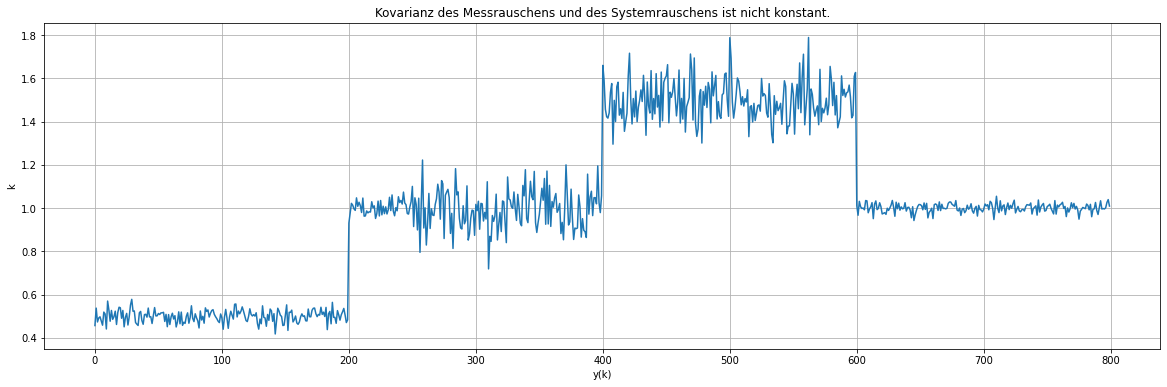

In [3]:
plt.figure(figsize=(20,6))
plt.title("Kovarianz des Messrauschens und des Systemrauschens ist nicht konstant.")
plt.xlabel("y(k)")
plt.ylabel("k")
plt.grid(True)
plt.plot(conts_noise)
plt.show()

# Alpha-Filter

In [4]:
class AlphaKalmanFilterVereinfacht():
    def __init__(self, alpha: np.float32, y_init: np.float32):
        self.K = alpha
        self.x_dach = y_init
        
        self.C = 1
        self.D = 0
        

    def correct(self, y: np.float32, u: np.float32):
        d_y = y
        self.x_tilde = self.x_dach + self.K*(d_y - self.C*self.x_dach - self.D*u)
        #self.x_tilde = self.K*d_y + (1 - self.K)*self.x_dach
    
        return {"x_tilde": self.x_tilde}
    
    def predict(self, u: np.float32):
        self.x_dach = self.x_tilde
        
        return {"x_dach": self.x_dach}

# ROSE-Filter

![](Rose_Modell.png)

In [5]:
class ROSEAlphaKalmanFilterE():
    def __init__(self, alpha_R: float, alpha_M: float, 
                 Ad: np.array, Bd: np.array, Gd: np.array, 
                 D: float, C: np.array, y_init: float, R_corr: float):
        self.Ad = Ad
        self.Bd = Bd
        self.Gd = Gd
        self.D = D
        self.C = C
        self.R_correction = R_corr
        
        self.R1_estim = AlphaKalmanFilterVereinfacht(alpha_R, y_init)
        self.R2_estim = AlphaKalmanFilterVereinfacht(alpha_R, y_init*y_init.T)
        
        self.M_estim = AlphaKalmanFilterVereinfacht(alpha_M, 0)
        self.P_tilde = np.float32(30*1)
        self.x_dach = y_init    
    
    def correct(self, y: np.array, u: np.float32):
        d_y = y - self.C*self.x_dach - self.D*u
        
        M = self.M_estim.correct(d_y*d_y.T, u)["x_tilde"]
        self.M_estim.predict(u)

        E1 = self.R1_estim.correct(y, u)["x_tilde"]
        self.R1_estim.predict(u)
        
        EE1 = self.R2_estim.correct(y*y.T, u)["x_tilde"]
        self.R2_estim.predict(u)
    
        R = self.R_correction*(EE1 - E1*E1.T)

        Q = self.Gd * (self.C.T*(M-R)*self.C - self.Ad*self.P_tilde*self.Ad.T) * self.Gd
        if Q < 0:
            Q = 0.0
        
        self.P_dach = self.Ad*self.P_tilde*self.Ad.T + self.Gd*Q*self.Gd.T
        K = self.P_dach*self.C.T* (self.C*self.P_dach*self.C.T + R)**(-1)
        self.x_tilde = self.x_dach + K*d_y
        self.P_tilde = (np.identity(n=1) - K*self.C)*self.P_dach
        
        return {"K": K, "x_tilde": self.x_tilde, "P_tilde": self.P_tilde, "P_dach": self.P_dach, "Q": Q, "R": R}
    
    def predict(self, u: np.float32):
        self.x_dach = self.Ad*self.x_tilde + self.Bd*u
        return {"x_dach": self.x_dach}

In [6]:
y = np.array([np.array([elem]) for elem in conts_noise])
u = np.zeros(len(y))
Ts = 1
rose = ROSEAlphaKalmanFilterE(0.3, 0.5, np.array([1]), np.array([0]), \
                             np.array([Ts]), np.array([0]), np.array([1]), y[0], 9.0)

Pp_tilde = list()
p_tilde = list()

R = list()
Q = list()

for y_elem, u_elem in zip(y, u):
    corrected_values = rose.correct(y_elem, u_elem)
    
    Pp_tilde.append(float(corrected_values["P_tilde"]))
    p_tilde.append(float(corrected_values["x_tilde"]))
    R.append(float(corrected_values["R"]))
    Q.append(float(corrected_values["Q"]))
    
    predicted_values = rose.predict(u_elem)


p_tilde = np.asarray(p_tilde)
Pp_tilde = np.asarray(Pp_tilde)

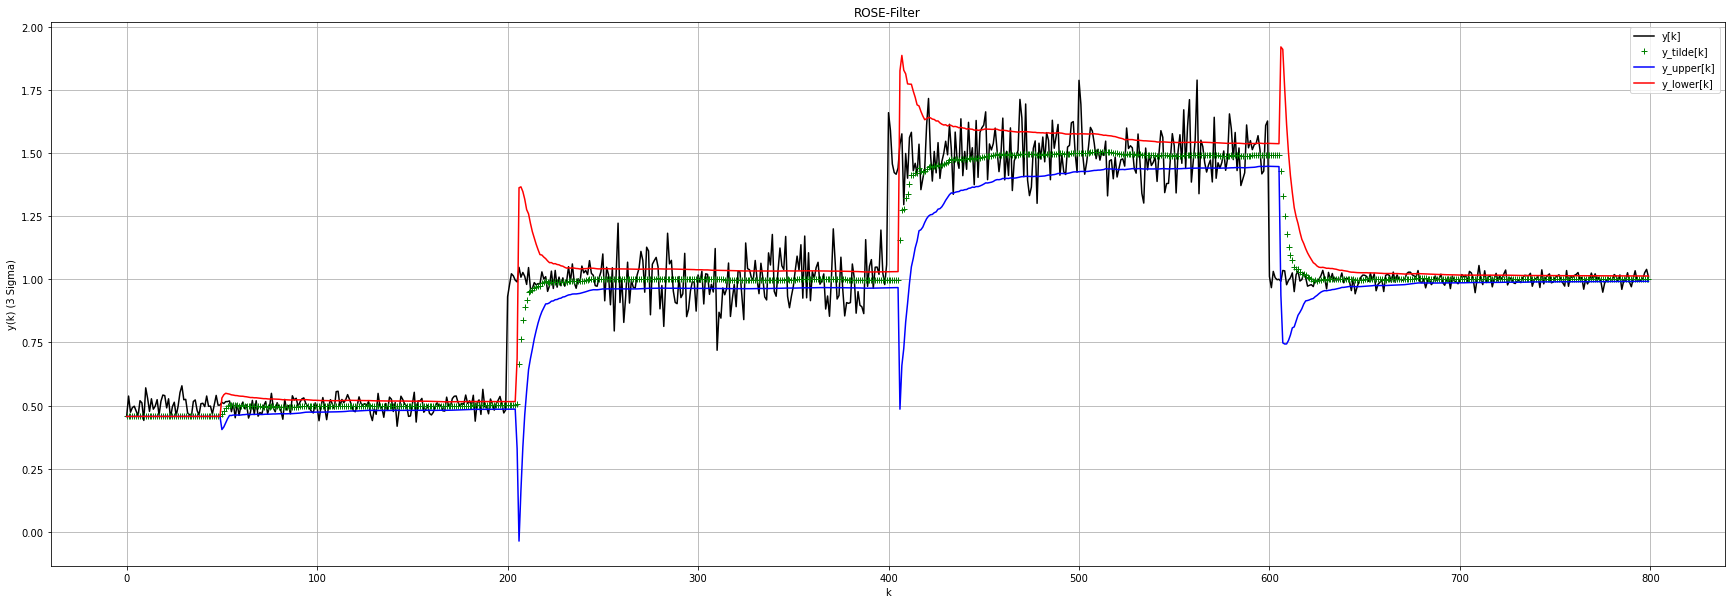

In [7]:
plt.figure(figsize=(30,10))
plt.title("ROSE-Filter")
plt.ylabel("y(k) (3 Sigma)")
plt.xlabel("k")
plt.grid(True)
plt.plot(y, 'k-', label="y[k]")
plt.plot(p_tilde, 'g+', label="y_tilde[k]")
plt.plot(p_tilde-3*(Pp_tilde**0.5), 'b-', label="y_upper[k]")
plt.plot(p_tilde+3*(Pp_tilde**0.5), 'r-', label="y_lower[k]")
#plt.xlim(6.0, 7.5)
#plt.ylim(25,33)
plt.legend()
plt.show()

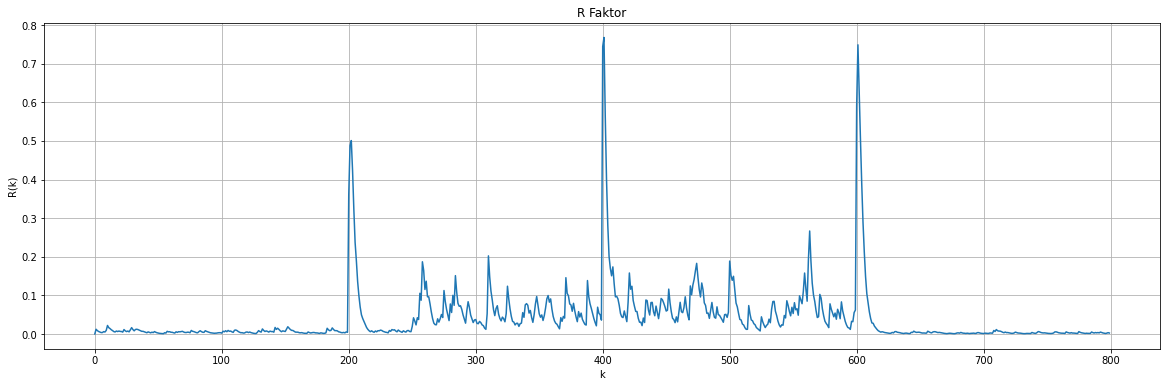

In [8]:
plt.figure(figsize=(20,6))
plt.title("R Faktor")
plt.xlabel("k")
plt.ylabel("R(k)")
plt.grid(True)
plt.plot(R)
plt.show()

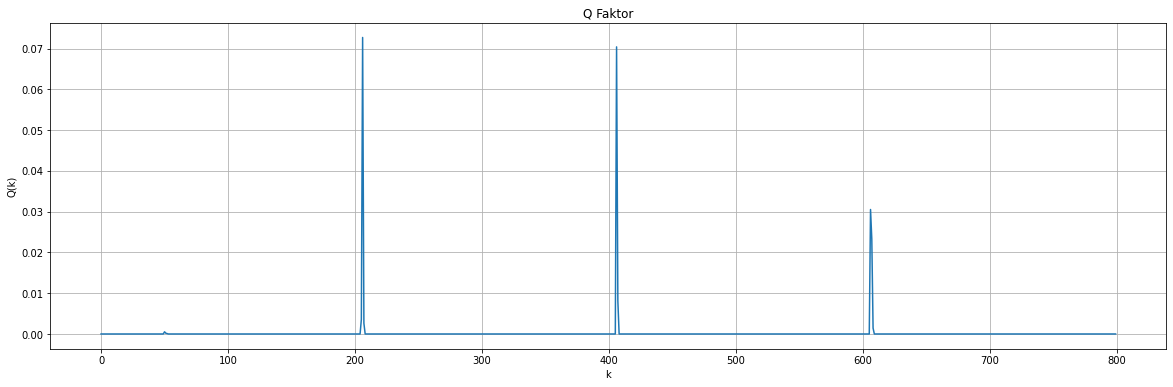

In [9]:
plt.figure(figsize=(20,6))
plt.title("Q Faktor")
plt.xlabel("k")
plt.ylabel("Q(k)")
plt.grid(True)
plt.plot(Q)
plt.show()